In [1]:
import pickle
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import keras.optimizers
from keras.layers import Dense, Input, Flatten, BatchNormalization, LSTM, Bidirectional, Dropout
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from new_data.data_preprocessing import TRAINING_USERS, PROBE_SIZE
import sys

In [2]:
INPUT_SIZE = (32, PROBE_SIZE)  # number of attributes - it will be the size of an input vector
print(PROBE_SIZE)
ENROLL_SIZE = 10

np.set_printoptions(threshold=sys.maxsize)

40


In [3]:
def read_data():
    """
    Read data from two pickle files with training and evaluation data.

    :return: train_data and eval_data dictionaries
    """

    with open("./new_data/training_data.pickle", "rb") as file:
        train_data = pickle.load(file)

    with open("./new_data/evaluation_data.pickle", "rb") as file:
        eval_data = pickle.load(file)

    return train_data, eval_data

In [4]:
def check_score(sample, template):
    """
    Checking the cosine similarity (which is a biometric score) between
    template and sample vectors.

    :param sample: First vector
    :param template: Second vector
    :return: Float value indicating biometric score
    """

    # Transforming vectors so they are in proper dimensions
    a = np.expand_dims(sample, axis=0)
    b = np.expand_dims(template, axis=0)
    score = cosine_similarity(a, b)
    # score is formatted as [[float]] so return just the value
    return score[0][0]

In [5]:
def prepare_data(train_data):
    """
    Prepare data for model training. Divide data into train and valid.

    :param train_data: dictionary with training data
    :return: tuple of six arrays
    """

    X = []
    Y = []

    for person_id in train_data.keys():
        for sample in train_data[person_id]:
            X.append(sample)
            Y.append(person_id)

    X = np.array(X)
    Y = np.array(Y)

    Y_oneshot = to_categorical(Y, num_classes=TRAINING_USERS)
    X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y_oneshot, test_size=0.2, random_state=123)
    return X, Y, X_train, X_valid, Y_train, Y_valid

In [6]:
def create_model(X, X_train, X_valid, Y_train, Y_valid):
    
    model = Sequential()
    forward_LSTM = LSTM(units=32, return_sequences=False)
    backward_LSTM = LSTM(units=32, return_sequences=False, go_backwards=True)

    model.add(Input(shape=INPUT_SIZE))
    model.add(BatchNormalization())
    model.add(Bidirectional(forward_LSTM, backward_layer=backward_LSTM, input_shape=INPUT_SIZE))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(TRAINING_USERS, activation="softmax"))

    select_optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=select_optimizer, metrics=['accuracy'])
    model.summary()

    # batch size indicates the number of observations to calculate before updating the weights
    history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=32, batch_size=32)
    vector_probes = model.predict(X)

    print(model.evaluate(X_valid, Y_valid, batch_size=50))

    central_vector = np.mean(vector_probes, axis=0)

    return model, central_vector, history

In [7]:
def enroll_users(model, eval_data, central_vector):

    enroll = {}  # key = person_id ; value = template
    test = {}  # key = person_id ; value = samples (1 or more)

    for person_id in eval_data.keys():

        # Divide the dataset into enroll and test vectors for each user
        # SEP samples for enroll and the rest for test
        SEP = ENROLL_SIZE

        # ENROLLMENT VECTOR
        temp = eval_data[person_id][:SEP]
        output = model.predict(np.array(temp))
        out_vector = np.mean(output, axis=0)
        enroll[person_id] = np.subtract(out_vector, central_vector)

        # TEST VECTORS
        test_vectors = []
        temp = eval_data[person_id][SEP:]
        output = model.predict(np.array(temp))
        for t in output:
            test_vectors.append(np.subtract(t, central_vector))
        test[person_id] = np.array(test_vectors)

    return enroll, test

In [8]:
def cross_evaluate(enroll, test):

    confidence_TP_MLP = []
    confidence_TN_MLP = []
    for userA in enroll.keys():
        userA_model = enroll[userA]
        A = []
        B = []
        # testing with the same user's test vectors
        for t in test[userA]:
            a = check_score(userA_model, t)
            confidence_TP_MLP.append(a)
            A.append(a)
        # testing with other users' test vectors
        for userB in test.keys():
            if userB != userA:
                for t in test[userB]:
                    b = check_score(userA_model, t)
                    confidence_TN_MLP.append(b)
                    B.append(b)

    confidence_TP_MLP = np.squeeze(np.array(confidence_TP_MLP))
    confidence_TN_MLP = np.squeeze(np.array(confidence_TN_MLP))

    with open("./model/confidence_TP.pickle", 'wb') as file:
        pickle.dump(confidence_TP_MLP, file)
    with open("./model/confidence_TN.pickle", 'wb') as file:
        pickle.dump(confidence_TN_MLP, file)

    return confidence_TP_MLP, confidence_TN_MLP

In [9]:
def model_accuracy_figure(history):

    # Model accuracy
    plt.figure()
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Dokładność modelu")
    plt.ylabel("Dokładność")
    plt.xlabel("Epoka")
    plt.legend(["Trening", "Walidacja"], loc="upper left")
    plt.savefig("./plots/model_accuracy.png")
    plt.show(block=False)

    # # Model loss
    # plt.figure()
    # plt.plot(history.history["loss"])
    # plt.plot(history.history["val_loss"])
    # plt.title("Model loss")
    # plt.ylabel("Loss")
    # plt.xlabel("Epoch")
    # plt.legend(["Train", "Test"], loc="upper left")
    # plt.savefig("./plots/model_loss.png")
    # plt.show(block=False)

2022-12-10 22:59:16.094872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 40)           160       
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               18688     
 l)                                                              
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

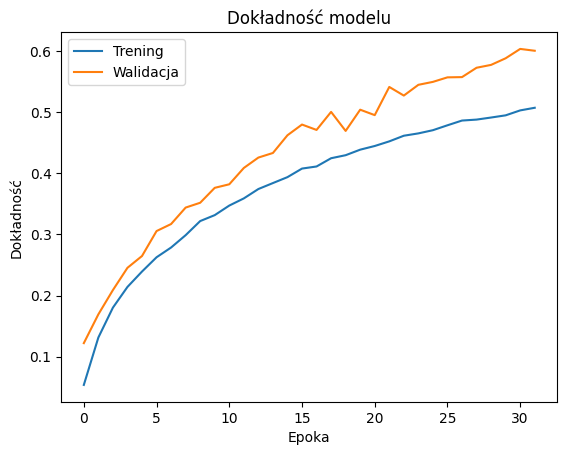

In [10]:
train_data, eval_data = read_data()
X, Y, X_train, X_valid, Y_train, Y_valid = prepare_data(train_data)

model, central_vector, history = create_model(X, X_train, X_valid, Y_train, Y_valid)
model_accuracy_figure(history)

In [11]:
def confidence_figure(confidence_TP_MLP, confidence_TN_MLP):
    # Number of true negatives vs number of true positives
    plt.figure()
    n_TP, bins_TP, patches_TP = plt.hist(confidence_TP_MLP, alpha=1, bins=1000)
    n_TN, bins_TN, patches_TN = plt.hist(confidence_TN_MLP, alpha=0.5, bins=1000)
    plt.legend(["wyniki True Positive", "wyniki True Negative"])
    plt.xlim([-1, 1])
    plt.xlabel("Wynik biometryczny")
    plt.ylabel("Liczba wystąpień")
    plt.grid()
    plt.savefig("./plots/confidence_TP_TN.png")
    plt.show(block=False)

    tn_sum = np.sum(n_TN)
    tp_sum = np.sum(n_TP)

    frr = np.cumsum(n_TP)
    for i in range(len(frr)):
        frr[i] /= tp_sum

    far = np.cumsum(n_TN)
    for i in range(len(far)):
        far[i] /= tn_sum
        far[i] = 1 - far[i]
        

    # FAR FRR figure
    plt.figure()
    plt.plot(bins_TP[1:], frr)
    plt.plot(bins_TN[1:], far)
    legend_f = ['false acceptance rate', 'false rejection rate']
    plt.legend(legend_f, loc='upper center')
    plt.xlabel('Próg biometryczny')
    plt.ylabel('Prawdopodobieństwo')
    plt.grid()
    plt.savefig("./plots/far_frr.png")
    plt.show(block=False)

    temp = [0 for _ in range(len(far))]
        
    for i in range(len(far)):
        temp[i] = abs(far[i] - frr[i])
    
    min_elem = temp.index(min(temp))
    print(far[min_elem], frr[min_elem], bins_TP[min_elem], bins_TN[min_elem])

2/2 [==============================] - 0s 3ms/step


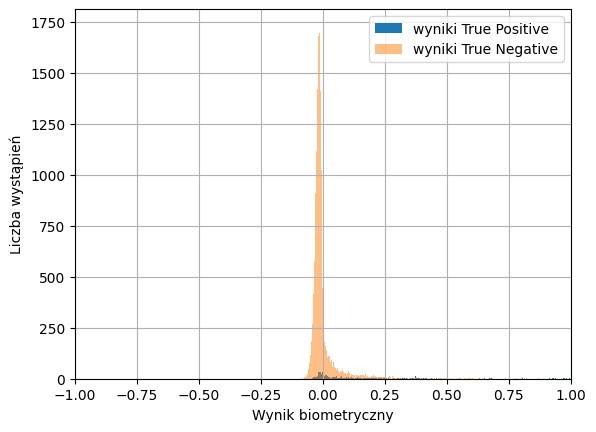

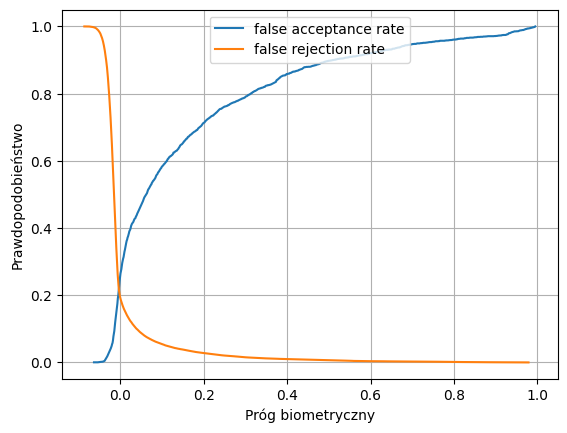

0.3395293540412523 0.3492291143779132 0.011703102 -0.010984834


In [12]:
ENROLL_SIZE = 10
enroll, test = enroll_users(model, eval_data, central_vector)
conf_TP, conf_TN = cross_evaluate(enroll, test)
confidence_figure(conf_TP, conf_TN)